In [1]:
# importing libraries.......
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

2022-11-13 11:13:10.696820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 11:13:10.792019: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-13 11:13:10.792033: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-13 11:13:10.814120: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 11:13:11.280847: W tensorflow/stream_executor/platform/de

In [3]:
# Loading parameters and dataset
platform = "PC"
# platform = 'RPi'
if platform != "PC":

    # import Interpreter
    # from tflite_runtime.interpreter import Interpreter

    
    #import libraries for led blinking
    from gpiozero import LED

    # Defining three LEDs
    dataLED = LED(23)
    attackLED = LED(24)
    detectionLED = LED(25)
# else:
#     # from tf.lite import Interpreter
#     import tensorflow.lite.Interpreter as Interpreter


# Defining IDs and number of associated signals
list_of_ids = list(range(1, 11))
num_of_id = [2, 3, 2, 1, 2, 2, 2, 1, 1, 4]
num_sigs_per_id = {}
for can_id, n_id in zip(list_of_ids, num_of_id):
    num_sigs_per_id[can_id] = n_id


# #Loading Raw Data Frame
folder_dir = 'data/syncan_cut/'
target_file = "test_flooding"
data_dir = folder_dir+target_file+'_cut.csv'

with open(data_dir,'r') as dest_f:
    data_iter = csv.reader(dest_f,
                           delimiter = ',',
                           quotechar = '"')
    data = [data for data in data_iter]
df_raw = pd.DataFrame(data)
df_raw.columns = ['Label', 'Time', 'ID','Signal1', 'Signal2', 'Signal3', 'Signal4']
df_raw = df_raw.drop(0)

In [4]:
# collected signals...
signals_in_cluster = ['Sig_2_of_ID_7',
 'Sig_2_of_ID_1',
 'Sig_1_of_ID_3',
 'Sig_2_of_ID_10',
 'Sig_2_of_ID_6',
 'Sig_1_of_ID_8',
 'Sig_3_of_ID_2',
 'Sig_1_of_ID_5',
 'Sig_1_of_ID_4',
 'Sig_1_of_ID_6',
 'Sig_2_of_ID_5',
 'Sig_3_of_ID_10',
 'Sig_2_of_ID_3',
 'Sig_1_of_ID_2',
 'Sig_1_of_ID_7',
 'Sig_2_of_ID_2',
 'Sig_1_of_ID_1',
 'Sig_4_of_ID_10',
 'Sig_1_of_ID_10',
 'Sig_1_of_ID_9']

In [5]:
time_data = []

In [6]:
dataset = 'syncan'

In [7]:
# # Converting saved model to a TensorFlow Lite model.
# for w in [20, 50, 100]:
#     T_x = 1
#     filename = f'models/lite_models//Autoencoder_Final_{w}_1_{T_x}_True'
#     converter = tf.lite.TFLiteConverter.from_saved_model(filename)
#     tflite_model = converter.convert()
#     open(f'models/tflite_models//Autoencoder_Final_{w}_1_{T_x}_True.tflite' , "wb") .write(tflite_model)
#     # Set interpreter...
#     interpreter = tf.lite.Interpreter(model_content=tflite_model)
# # print(interpreters)

In [11]:
for model_type in ['Lite', 'Original']:
    for w in [20, 50, 100]:
    # for w in [25]:
        # Design hyper-parameters....
        T_xs = [1]
        q = max(T_xs)*w
        n = len(signals_in_cluster)

        # Loading autoencoders....
        autoencoders = {}
        interpreters = {}

        for T_x in T_xs:

            if model_type == 'Original':
                filename = f'models/lite_models//Autoencoder_Final_{w}_1_{T_x}_True'
                # filename = f'models/original_models//Autoencoder_Final_{w}_1_{T_x}_True.h5'
                autoencoders[T_x] = load_model(filename)
                # print(autoencoders)
            # else:
            #     # Converting saved model to a TensorFlow Lite model.
            #     filename = f'models/lite_models//Autoencoder_Final_{w}_1_{T_x}_True'
            #     converter = tf.lite.TFLiteConverter.from_saved_model(filename)
            #     tflite_model = converter.convert()
            #     # Set interpreter...
            #     interpreters[T_x] = tf.lite.Interpreter(model_content=tflite_model)
            #     # print(interpreters)
            else:
                filename = f'models/tflite_models//Autoencoder_Final_{w}_1_{T_x}_True.tflite'
                
                if platform == 'PC':
                    interpreters[T_x] = tf.lite.Interpreter(model_path = filename)
                elif platform == 'RPi':
                    interpreters[T_x] = tflite_runtime.interpreter.Interpreter(model_path = filename) 
                


        #Setting up thresholds....
        R_loss = np.random.rand(n)
        R_time = (np.random.rand(n)*n).astype(int)
        R_signal = np.random.randint(n)


        # Initiating the dataQ
        dataQ = pd.DataFrame(np.zeros((q, n), dtype = float), columns = signals_in_cluster)
        dataQ.index = dataQ.index + 1

        print("Initiating analysis.... ", w)
        for index, data in enumerate(df_raw.values):   

            begin_time = datetime.datetime.now()
            #Reading data from the CAN bus in decoded foramt
            can_id = int(data[2][2:])
            signals_reported = [f'Sig_{i+1}_of_ID_{can_id}' for i in range(num_sigs_per_id[can_id])]
            signals_missing = set(signals_in_cluster) - set(signals_reported)

            # Updating dataQ    
            new_data = [float(x) for x in data[3:3+num_sigs_per_id[can_id]]].copy()
            dataQ.loc[2:q] = dataQ.loc[1:q-1].values.copy()
            dataQ.loc[1, signals_reported] = new_data.copy()
            dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
            time_elapsed = datetime.datetime.now() - begin_time
            time_needed_dataQ = float(time_elapsed.total_seconds())


            #Creating different views and predicting reconstrcuted image
            anomaly_S_ens = 0
        #     prediction_time = 0
        #     analysis_time = 0


            for T_x in T_xs:       

                prediction_time = 0
                analysis_time = 0

                # Creating different views.....
                #starting timer

                
                dataV_org = dataQ.loc[1:(w*T_x):T_x].values.reshape(1, w, n, 1).copy()
                dataV_org = np.array(dataV_org, dtype=np.float32)
                
                if model_type != 'Original':
                    dataV_org = np.array(dataV_org, dtype=np.float32)

                begin_time = datetime.datetime.now()

                # Predict.....
                if model_type == 'Original':
                    # print("autoencoders", autoencoders)
                    dataV_recon = autoencoders[T_x].predict(dataV_org)
                
                else:
                    # print("interpreters", interpreters)
                    interpreter = interpreters[T_x]
                    interpreter.allocate_tensors() 
                    #get input and output tensors
                    input_details = interpreter.get_input_details()
                    output_details = interpreter.get_output_details()

                    #set the tensor to point to the input data to be inferred
                    input_index = input_details[0]["index"]
                    interpreter.set_tensor(input_index, dataV_org)
                    #Run the inference
                    interpreter.invoke()
                    output_details = interpreter.get_output_details()
                    # Output
                    dataV_recon = interpreter.get_tensor(output_details[0]['index'])
                    

                        

                #stopping timer
                time_elapsed = datetime.datetime.now() - begin_time
                prediction_time += float(time_elapsed.total_seconds())
                
    #             dataV_recon = dataV_recon[0,:,:,0].copy()

                #starting timer
                begin_time = datetime.datetime.now()

                dataV_loss = abs(dataV_org - dataV_recon)[0,:,:,0].copy()
                #finding anomaly scores for individual models...
                anomaly_B = (dataV_loss > R_loss).astype(int)
                anomaly_C = np.sum(anomaly_B,0)
                anomaly_S = np.sum(anomaly_C > R_time)
                anomaly_S_ens += anomaly_S

                #stopping timer
                time_elapsed = datetime.datetime.now() - begin_time
                analysis_time  += float(time_elapsed.total_seconds())

                time_data.append([w, T_x, time_needed_dataQ, prediction_time, analysis_time, model_type])



        #         if anomaly_S > R_signal:
        #             predictions[T_x].append(1)
        #         else:
        #             predictions[T_x].append(0)    


            # Checking the final ensemble score..
        #     if anomaly_S_ens > R_signal_ens:
        #         predictions['Ens'].append(1)
        #     else:
        #         predictions['Ens'].append(0)   

        #     time_data.append([w, T_x, time_needed_dataQ, prediction_time, analysis_time])

            if index == 100:
                break

Initiating analysis....  20


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning

Initiating analysis....  50


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

Initiating analysis....  100


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

Initiating analysis....  20
1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - ETA: 0s

/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 18ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step
Initiating analysis....  50
1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - ETA: 0s

/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step
Initiating analysis....  100
1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 18ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataQ.loc[1, signals_missing] = dataQ.loc[2, signals_missing].copy()
/tmp/ipykernel_28632/3978981867.py:61: FutureWarning: Passing a set as an indexer is deprecated and will rai

In [12]:
time_df = pd.DataFrame(time_data, columns = ['w', 'Tx', 'Data Queue', 'Prediction', 'Analysis', 'Model Type'])
time_df[['Data Queue', 'Prediction', 'Analysis']]*= 1000

In [13]:
time_df

,w,Tx,Data Queue,Prediction,Analysis,Model Type
0,20,1,7.993,244.111,0.258,Original
1,20,1,3.222,37.754,0.106,Original
2,20,1,2.408,37.236,0.126,Original
3,20,1,2.935,36.709,0.109,Original
4,20,1,2.336,36.238,0.090,Original
...,...,...,...,...,...,...
904,100,1,2.797,43.963,0.127,Original
905,100,1,2.497,37.533,0.149,Original
906,100,1,2.628,37.010,0.115,Original
907,100,1,2.053,37.725,0.206,Original


In [14]:
time_df.to_csv('framework_performance.csv', header = True, index = True)

In [15]:
import seaborn as sns

# sns.barplot(data = time_df, x = 'w', y = 'Prediction')
# sns.barplot(data = time_df, x = 'w', y = 'Data Queue')
# sns.barplot(data = time_df, x = 'w', y = 'Analysis')

<AxesSubplot: xlabel='Model Type', ylabel='Data Queue'>

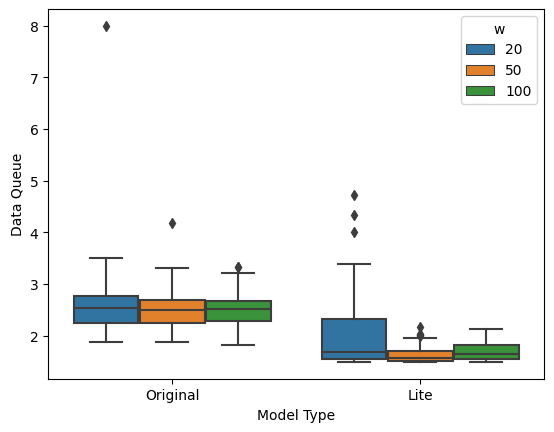

In [16]:
sns.boxplot(data = time_df, hue = 'w', y = 'Data Queue', x = 'Model Type')

<AxesSubplot: xlabel='Model Type', ylabel='Prediction'>

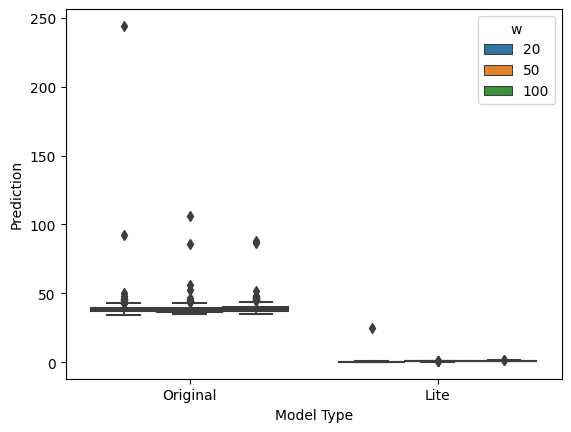

In [18]:
sns.boxplot(data = time_df, hue = 'w', y = 'Prediction', x = 'Model Type')

<AxesSubplot: xlabel='Model Type', ylabel='Prediction'>

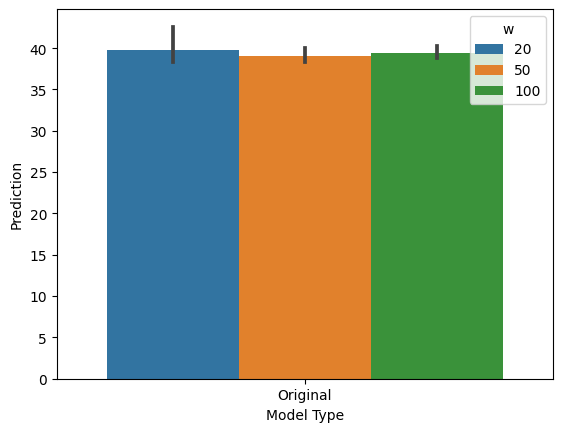

In [19]:
sns.barplot(data = time_df[time_df['Model Type'] == 'Original'], hue = 'w', y = 'Prediction', x = 'Model Type')

<AxesSubplot: xlabel='Model Type', ylabel='Prediction'>

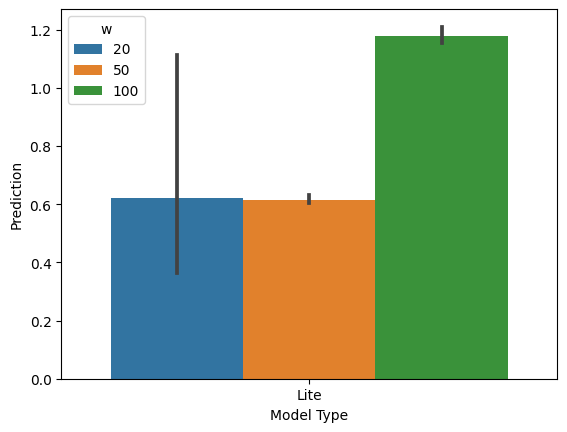

In [20]:
sns.barplot(data = time_df[time_df['Model Type'] == 'Lite'], hue = 'w', y = 'Prediction', x = 'Model Type')

<AxesSubplot: xlabel='Model Type', ylabel='Analysis'>

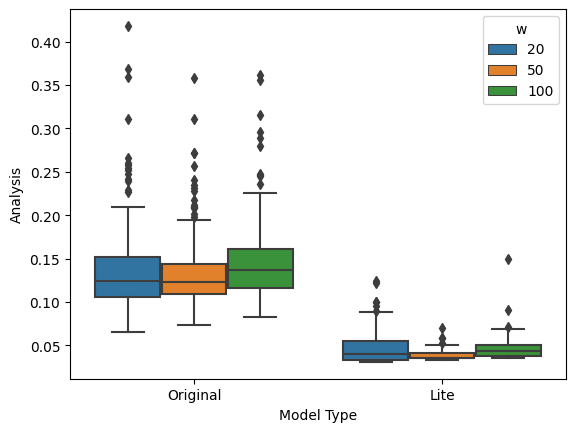

In [21]:
sns.boxplot(data = time_df, hue = 'w', y = 'Analysis', x = 'Model Type')

In [22]:
# df_raw['Time'] = df_raw['Time'].astype(float)

# df_raw['Time'][0:100].iloc[0] - df_raw['Time'][0:100].iloc[-1]

In [23]:
# df_raw['Time'][0:100][1]